In [1]:
%matplotlib inline
!pip install deeptrack

<!--<badge>--><a href="https://colab.research.google.com/github/softmatterlab/DeepTrack-2.0/blob/develop/examples/LodeSTAR/09.measure_mass_experimental.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->

In [2]:
import random

import deeptrack as dt
import deeptrack.extras
import numpy as np
import skimage.color
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy.io

deeptrack.extras.datasets.load("ParticleSizing")

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\backend\_config.py:11: UserWarning: cupy not installed. GPU-accelerated simulations will not be possible
  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\backend\_config.py:25: UserWarning: cupy not installed, CPU acceleration not enabled
  warnings.warn("cupy not installed, CPU acceleration not enabled")


Dataset already downloaded.


In [3]:
import numpy as np
import matplotlib.pyplot as plt

crop_size = 32
padding = 32
wavelength = 633e-9 
pixel_size = 114e-9
crop_propagation_forward = dt.get_propagation_matrix((crop_size + 2 * padding, ) * 2, 1e-7, pixel_size * 2, wavelength)
crop_propagation_backward = dt.get_propagation_matrix((crop_size + 2 * padding, ) * 2, -1e-7, pixel_size * 2, wavelength)

experimental_data = np.load('datasets/ParticleSizing/sizing_150nm_227nm_PSL.npy', allow_pickle=True)

trace = experimental_data[1]
trace[..., 0] += 1
import random
training_set = dt.Value(lambda: trace[0]) >> dt.AveragePooling((2, 2, 1))


In [4]:
args = dt.Arguments(
    translate=lambda: np.random.randn(2) * 1,
    rotate=lambda:np.random.uniform(0, np.pi*2),
    z=lambda: np.random.randint(-4, 4),
    rescale=lambda: 10**np.random.uniform(-1, 0.5)
)

group = ( 
     dt.Affine(rotate=args.rotate) 
    >>dt.Affine(translate=args.translate) 
    >> dt.Rescale(args.rescale) 
    >> dt.FourierTransform() 
    >> dt.FourierTransformTransformation(crop_propagation_forward, crop_propagation_backward, args.z) 
    >> dt.InverseFourierTransform() 
    >> dt.Gaussian(sigma=lambda: np.random.rand() * 0.0075)
)

equivariance = (
    dt.models.lodestar.Rotational2DEquivariance(args.rotate)
    >> dt.models.lodestar.TranslationalEquivariance(args.translate)
    
    # >> dt.models.lodestar.Equivariance(1, args.z / 10, indexes=2)
    >> dt.models.lodestar.Equivariance(1, lambda arg: np.log(arg), arg = args.rescale, indexes=2)
)




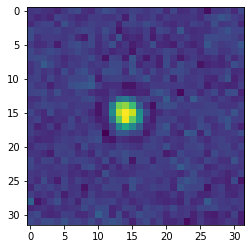

In [5]:
out = (training_set >> group).update()()
plt.imshow(out[..., 1])

In [6]:
generator = dt.models.lodestar.LodeSTARGenerator(
    training_set,
    3,
    (group, equivariance), 
    batch_size=8, 
    min_data_size=200, 
    max_data_size=201
)



In [7]:

with generator:
    model = dt.models.LodeSTAR(input_shape=(None, None, 2), num_outputs=3)
    model.compile(loss="mae", optimizer=tf.keras.optimizers.Adam())
    model.fit(generator, epochs=50, steps_per_epoch=100)


Generating 201 / 200 samples before starting training
Epoch 1/50
100/100 [==============================] - 4s 11ms/step - total_loss: 2.0121 - consistency_loss: 1.2124
Epoch 2/50
100/100 [==============================] - 1s 11ms/step - total_loss: 1.8571 - consistency_loss: 1.0343
Epoch 3/50
100/100 [==============================] - 1s 11ms/step - total_loss: 1.4229 - consistency_loss: 0.6418
Epoch 4/50
100/100 [==============================] - 1s 10ms/step - total_loss: 0.9230 - consistency_loss: 0.2543
Epoch 5/50
100/100 [==============================] - 1s 11ms/step - total_loss: 1.1679 - consistency_loss: 0.3230
Epoch 6/50
100/100 [==============================] - 1s 10ms/step - total_loss: 0.7866 - consistency_loss: 0.1966
Epoch 7/50
100/100 [==============================] - 1s 11ms/step - total_loss: 0.3677 - consistency_loss: 0.0974
Epoch 8/50
100/100 [==============================] - 1s 11ms/step - total_loss: 0.1706 - consistency_loss: 0.0387
Epoch 9/50
100/100 [======

In [8]:
res = []
for d in experimental_data:
    d = dt.AveragePooling(ksize=(1, 2, 2, 1))(d)._value
    
    if np.mean(d[..., 0]) < 0.5:
        d[..., 0] += 1
    preds = model.predict_and_pool(np.array(d))
    res.append(preds)

6/6 [==============================] - 0s 4ms/step


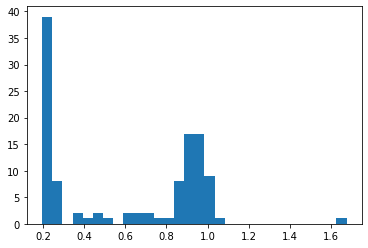

In [9]:
out2 = []
for d in res:
    out2.append(np.mean(d[:, 2]))
out2 = np.exp(out2)
out2 = out2 / np.quantile(out2, 0.95)

plt.hist(out2, 30)

outa = np.zeros((0,))
outb = np.zeros((0,))
for d, o0 in zip(res, out2):
    vals = dt.convolve(d[:, 2], np.ones((15,))/15)[::15]
    if 1.3 > o0 > 0.7:
        outa = np.concatenate((outa, vals), axis=0)
    if o0 < 0.4:
        outb = np.concatenate((outb, vals), axis=0)
outa = np.exp(outa)
outb = np.exp(outb)


In [10]:
particle_a_ph = 0.228**3 * (1.58**2 - 1.33**2) / (1.58**2 + 1.33**2 * 2) * 1000 * 4 * np.pi
particle_b_ph = 0.150**3 * (1.58**2 - 1.33**2) / (1.58**2 + 1.33**2 * 2) * 1000 * 4 * np.pi

norm_factor = particle_a_ph / np.median(outa)

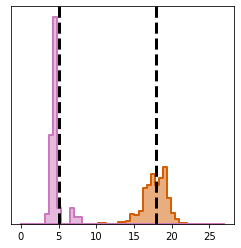

In [11]:
import seaborn as sns

plt.figure(figsize=(4, 4))
sns.histplot(outa * norm_factor, bins=50, binrange=(0, particle_a_ph * 1.5), color=sns.color_palette("colorblind")[3], alpha = .5, stat="probability", element="step", linewidth=2)
sns.histplot(outb * norm_factor, bins=50, binrange=(0, particle_a_ph * 1.5), color=sns.color_palette("colorblind")[4], alpha = .5, stat="probability", element="step", linewidth=2)

plt.axvline(particle_a_ph, c="k", linestyle="--", linewidth=3)
plt.axvline(particle_b_ph, c="k", linestyle="--", linewidth=3)
plt.yticks([])
# plt.xticks(np.array([0, 2, 4, 6, 8, 10, 12, 14]) * 2)
plt.ylabel("")
# plt.ylim([0, 60])
plt.savefig("fig4e.svg", bbox_inches="tight")
